# Import libraries

In [1]:
import pandas as pd
import csv
import re
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 
import spacy
import community as community_louvain

from selenium import webdriver 
from spacy import displacy
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from pyvis.network import Network
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from functions.lotr_functions import *

# Load characters

In [3]:
# Create driver

# URLs with characters from movies
page_urls = ["https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring", "https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Two_Towers", "https://lotr.fandom.com/wiki/The_Lord_of_the_Rings:_The_Return_of_the_King"]

# Get all characters from movies'
characters_list_df = download_characters_from_web(page_urls)

# Add unique characters from book
characters_list_df = compare_two_sources(characters_list_df, "https://tolkiengateway.net/wiki/Category:Characters_in_The_Lord_of_the_Rings")


ValueError: cannot set a row with mismatched columns

In [12]:
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.common.by import By
    from selenium.webdriver import ActionChains
    from selenium.webdriver.common.keys import Keys
    from selenium.common.exceptions import NoSuchElementException
    #get all characters from book
    service = webdriver.ChromeService()
    driver = webdriver.Chrome(service=service)
    page_url="https://tolkiengateway.net/wiki/Category:Characters_in_The_Lord_of_the_Rings"
    driver.get(page_url)

    #list with characters from second source 
    book_characters=[]

    book_characters_unique=[]

    #find div with characters 
    book_table_with_characters=driver.find_element(By.CLASS_NAME, 'mw-category')

    #find all characters inside of div with characters 
    book_character_elements=book_table_with_characters.find_elements(By.TAG_NAME, 'a')

    [book_characters.append({"character_name": character.text, "character_url": character.get_attribute('href')}) for character in book_character_elements]

    last_index_of_df=characters_list_df['character_key'].tail(1).index[0]
    for i, item in enumerate(book_characters):
        if item["character_name"] not in list(characters_list_df.character_name) and item["character_name"].split(' ', 1)[0] not in list(characters_list_df.character_firstname):
            last_index_of_df=last_index_of_df+1
            characters_list_df.loc[len(characters_list_df.index)] = [last_index_of_df, item["character_name"], item["character_name"].split(' ', 1)[0], [], "", item["character_url"]]
            book_characters_unique.append(item)
    driver.close()    

# Load books and create relationships

In [15]:
# Get all book files in the data directionary
all_books= [b for b in os.scandir('data/books') if '.txt' in b.name]

In [17]:
# Dataframe with sentence and entities
sent_entity_df_all=pd.DataFrame(columns=['sentence','entities','character_entities', 'book_id'])

# Dataframe with relationships of two entities
relationships_df_all=pd.DataFrame(columns=['source','target','value', 'book_id'])

# loop through book list
for num, book in enumerate(all_books):
    
    book_doc=get_book_text(book)

    # Get entity list per sentence
    sent_entity_df=get_entity_list_per_sentence(book_doc)
   
    # Select sentences only with characters' names
    sent_entity_df['character_entities']=sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_list_df))

    # Filter out sentences that don't have any character enitites
    sent_entity_df_filtered= sent_entity_df[sent_entity_df['character_entities'].map(len)>0]
    
    # Create relationships for current book
    relationships_df=create_relationships(df=sent_entity_df_filtered, window_size=8)
    
    # Save book_number for entities and relationships
    #sent_entity_df_filtered['book_id'] = num
    #sent_entity_df_all=pd.concat([sent_entity_df_all,sent_entity_df_filtered])
    
    #relationships_df['book_id'] = num
    #relationships_df_all=pd.concat([relationships_df_all, relationships_df])
    sent_entity_df_filtered.loc[:, 'book_id'] = num
    sent_entity_df_all = pd.concat([sent_entity_df_all, sent_entity_df_filtered])

    relationships_df.loc[:, 'book_id'] = num
    relationships_df_all = pd.concat([relationships_df_all, relationships_df])
    



C:\Users\Arina Lavrova\AppData\Local\Temp\ipykernel_12872\106430195.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered.loc[:, 'book_id'] = num
C:\Users\Arina Lavrova\AppData\Local\Temp\ipykernel_12872\106430195.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered.loc[:, 'book_id'] = num
C:\Users\Arina Lavrova\AppData\Local\Temp\ipykernel_12872\106430195.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [18]:
# Relationships for all books
relationships_df_throughout_all_books=pd.DataFrame(columns=['source','target','value'])
relationships_df_throughout_all_books=relationships_df_all.groupby(["source","target"], 
                                              sort=False, 
                                              as_index=False)['value'].sum()

# Graph visualisation

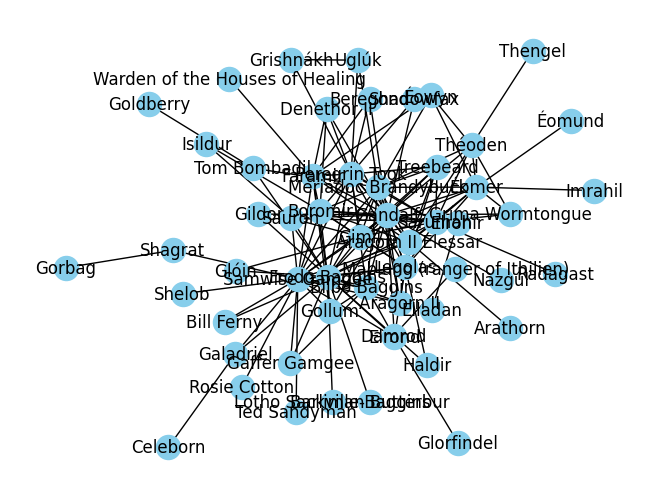

In [52]:
# Create a graph from a pandas dataframe - only first 200 rows (sorted)
G =nx.from_pandas_edgelist(relationships_df_throughout_all_books.sort_values(by='value', ascending=False).head(150),
                          source="source",
                          target="target", 
                          edge_attr="value",
                          create_using=nx.Graph())

pos= nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)


number_of_nodes=G.number_of_nodes()
number_of_edges=G.number_of_edges()

plt.savefig('graphs/graph_lotr.png')
plt.show()

In [27]:
relationships_df_throughout_all_books.sort_values(by='value', ascending=False)

,source,target,value
43,Frodo Baggins,Samwise Gamgee,4648
37,Meriadoc Brandybuck,Peregrin Took,1392
95,Aragorn II,Aragorn II Elessar,1327
261,Gimli,Legolas,1249
55,Gollum,Samwise Gamgee,1210
...,...,...,...
473,Gamling,Théoden,1
187,Balin,Sauron,1
581,Dervorin,Forlong,1
143,Eärendil,Meriadoc Brandybuck,1


## Graph visualization - Pyvis Network

In [53]:
net= Network(notebook = True, 
             width="1300px", 
             height="700px", 
             bgcolor="#000000", 
             font_color="#ffffff"
             #select_menu=True,
             #cdn_resources='remote'
             #filter_menu=True
            )

node_degree=dict(G.degree)

# Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("graphs/lord_of_rings.html")


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Character degree centrality

In [89]:
# sort desc node_degree
import operator
# Sort the dictionary by values in descending order
sorted_node_degree_desc = dict(sorted(node_degree.items(), key=lambda x: x[1], reverse=True))
# Sort the dictionary by values in ascending order
sorted_node_degree_asc = dict(sorted(node_degree.items(), key=lambda x: x[1], reverse=False))

# Get the first 10 items from the sorted dictionary
sorted_node_degree_desc = dict(list(sorted_node_degree_desc.items())[:10])
sorted_node_degree_asc =  dict(list(sorted_node_degree_asc.items())[:20])

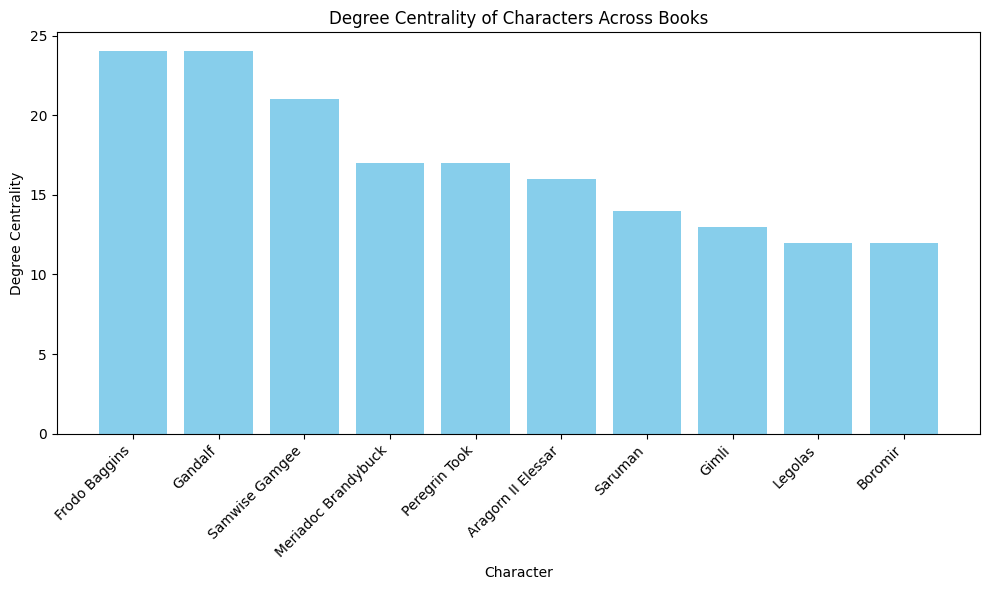

In [90]:
# Extract character names and degree centrality values
characters = list(sorted_node_degree_desc.keys())
degree_centrality = list(sorted_node_degree_desc.values())
# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(characters, degree_centrality, color='skyblue')
plt.xlabel('Character')
plt.ylabel('Degree Centrality')
plt.title('Degree Centrality of Characters Across Books')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('graphs/degree_centrality_desc.png')
plt.show()

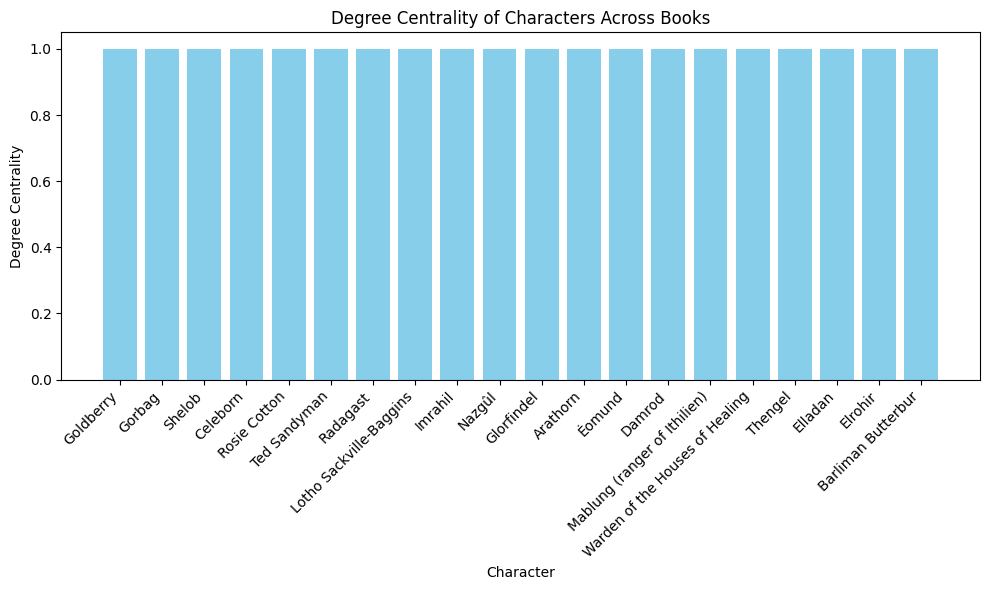

In [91]:
# Extract character names and degree centrality values
characters = list(sorted_node_degree_asc.keys())
degree_centrality = list(sorted_node_degree_asc.values())
# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(characters, degree_centrality, color='skyblue')
plt.xlabel('Character')
plt.ylabel('Degree Centrality')
plt.title('Degree Centrality of Characters Across Books')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('graphs/degree_centrality_acs.png')
plt.show()

In [29]:
# Build communities
communities= community_louvain.best_partition(G)

nx.set_node_attributes(G, communities, 'group')
com_net= Network(notebook = True, width="1300px", height="700px", bgcolor="#000000", font_color="#ffffff",select_menu=True, cdn_resources='remote')
com_net.from_nx(G)
com_net.show("graphs/lord_of_rings_comminities.html")

In [31]:
# Grouping dictionary keys by value
communities_dict_sorted = {}

for key, value in sorted(communities.items()):
    if len(key)>0:
        communities_dict_sorted.setdefault(value, []).append(key)
communities_dict_sorted=dict(sorted(communities_dict_sorted.items()))
communities_dict_sorted

# Create a dataframe from the dictionary
communities_df = pd.DataFrame.from_dict(communities_dict_sorted, orient='index').transpose()

# Remove any null values from the dataframe
communities_df = communities_df.replace('', pd.NA).dropna(how='all')

# Reset the index to start from 1
communities_df.index = range(1, len(communities_df) + 1)

communities_df=communities_df.fillna('')
communities_df
communities_dict_sorted

{0: ['Barliman Butterbur',
  'Celeborn',
  'Frodo Baggins',
  'Galadriel',
  'Gildor',
  'Glóin',
  'Goldberry',
  'Haldir',
  'Isildur',
  'Lotho Sackville-Baggins',
  'Sauron',
  'Tom Bombadil'],
 1: ['Bilbo Baggins',
  'Bill Ferny',
  'Elrond',
  'Gaffer Gamgee',
  'Gandalf',
  'Glorfindel',
  'Gollum',
  'Gorbag',
  'Nazgûl',
  'Rosie Cotton',
  'Samwise Gamgee',
  'Shadowfax',
  'Shagrat',
  'Shelob',
  'Ted Sandyman'],
 2: ['Damrod', 'Mablung (ranger of Ithilien)'],
 3: ['Beregond',
  'Boromir',
  'Denethor II',
  'Faramir',
  'Grishnákh',
  'Peregrin Took',
  'Uglúk',
  'Warden of the Houses of Healing'],
 4: ['Elladan', 'Elrohir'],
 5: ['Aragorn II',
  'Aragorn II Elessar',
  'Arathorn',
  'Gimli',
  'Gríma Wormtongue',
  'Imrahil',
  'Legolas',
  'Meriadoc Brandybuck',
  'Radagast',
  'Saruman',
  'Thengel',
  'Théoden',
  'Treebeard',
  'Éomer',
  'Éomund',
  'Éowyn']}

# Characters' importance over time

In [32]:
# Sort the 'relationships_df_all' dataframe by 'book_id' and 'value', grouping by 'book_id'
# and taking the top 10 rows from each group
relationships_df_all.sort_values(['book_id', 'value'], ascending=[True, False]).groupby('book_id').head(10)

# Initialize empty lists and dataframes
books_graph=[]
books_graph_weighted=[]
degree_centrality_nodes_all_books=pd.DataFrame(columns=['node','degree_centrality'])

# Loop over each book in 'all_books' and create a graph using the 'relationships_df_all' dataframe
for num, book in enumerate(all_books):
    # Subset the 'relationships_df_all' dataframe to only include relationships for the current book
    # Create a graph using the 'source', 'target', and 'value' columns of the subsetted dataframe
    G =nx.from_pandas_edgelist(relationships_df_all.loc[relationships_df_all['book_id'] == num],
                          source="source",
                          target="target", 
                          edge_attr="value",
                          create_using=nx.Graph())
    
    # Compute the degree centrality for each node in the graph
    degree_centrality_nodes=[]
    degree_centrality = nx.degree_centrality(G)
    
    # Sort the nodes by degree centrality and add them to the 'degree_centrality_nodes' list
    for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True):
        degree_centrality_nodes.append({"node": node, "degree_centrality": degree_centrality[node]})   
        
    # Convert the 'degree_centrality_nodes' list to a dataframe and append it to 'degree_centrality_nodes_all_books'
    degree_centrality_nodes_df = pd.DataFrame(degree_centrality_nodes).sort_values(by='degree_centrality', ascending=False)
    degree_centrality_nodes_all_books=pd.concat([degree_centrality_nodes_all_books, degree_centrality_nodes_df])
    
    # Add the graph to the 'books_graph' list
    books_graph.append(G)
    


In [37]:
# Select the top 8 most important characters based on degree centrality
degree_centrality_nodes_all_books=degree_centrality_nodes_all_books.sort_values(by='degree_centrality', ascending=False)
degree_centrality_nodes_all_books=degree_centrality_nodes_all_books.drop_duplicates(subset='node', keep="first").reset_index(drop=True).loc[0:7]
most_important_characters=degree_centrality_nodes_all_books["node"].tolist() 

<AxesSubplot: >

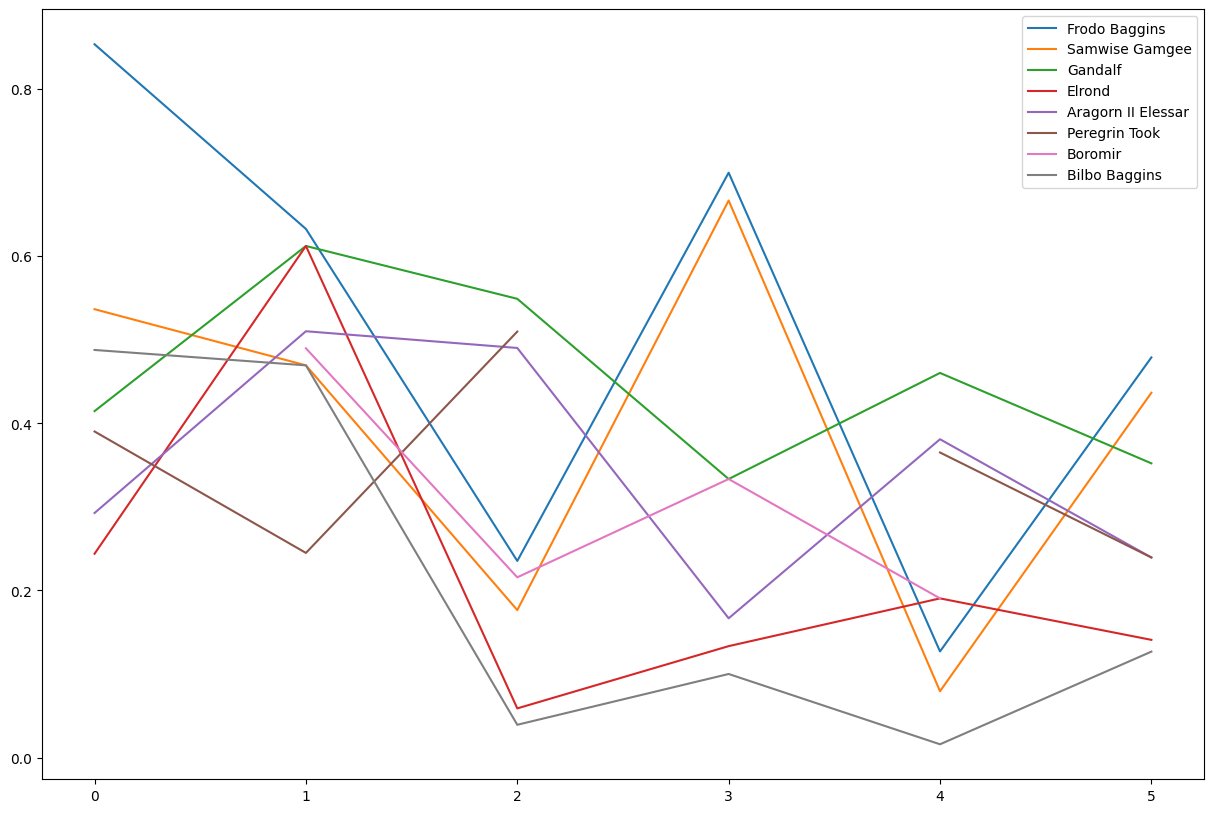

In [38]:
# Compute the degree centrality of each node in each book's graph
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plot the degree centrality evolution of the top 5 most important characters
degree_evol_df[most_important_characters].plot(figsize=(15,10))

## Positive Characters

<AxesSubplot: >

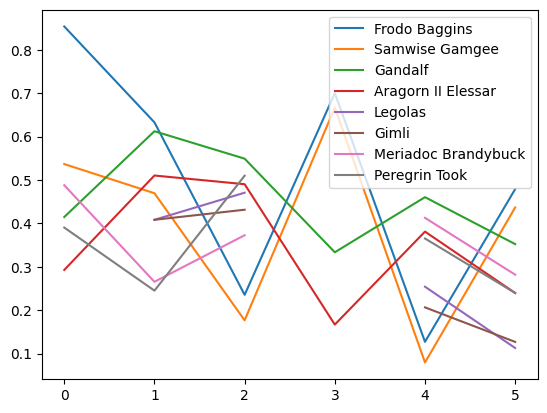

In [44]:
# Compute the degree centrality of each node in each book's graph
evol_pos = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_pos_df = pd.DataFrame.from_records(evol_pos)

# Plotting the degree centrality evolution of positive chracters  due to my opinion 
degree_evol_pos_df[["Frodo Baggins", "Samwise Gamgee", "Gandalf", "Aragorn II Elessar", "Legolas", "Gimli", "Meriadoc Brandybuck", "Peregrin Took"]].plot()

## Negative Characters

<AxesSubplot: >

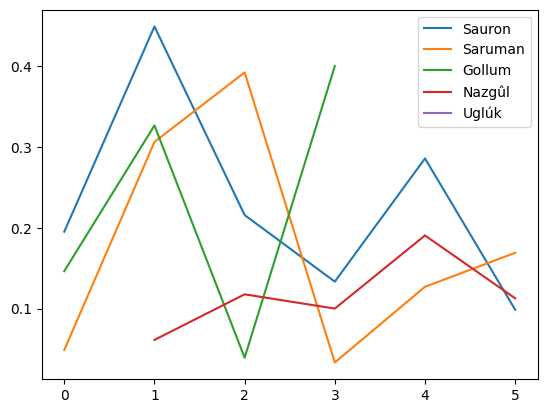

In [47]:
# Compute the degree centrality of each node in each book's graph
evol_neg = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_neg_df = pd.DataFrame.from_records(evol_neg)

# Plotting the degree centrality evolution of positive chracters  due to my opinion 
degree_evol_neg_df[["Sauron", "Saruman", "Gollum", "Nazgûl", "Uglúk"]].plot()

# Wordclouds

In [50]:
# Create wordcloud for each book
from spacy.lang.en import English
# Load the English NLP model
nlp = English()

# Load the default stop words from the en module in Spacy
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS

# Add SPACY stopwords to the stopwords set
# Add "said" to the stopwords set
stopwords = stopwords_spacy.union(STOPWORDS)
stopwords.update(["said"])

# Loop over each book in the all_books list
for num, book in enumerate(all_books):
    
    # Read the contents of the book
    book_text = open(book).read()
    
    #custom_mask = np.array(Image.open("wordclouds/siluets/"+str(num)+".png"))
    
    # Create a WordCloud object with the desired parameters
    wc=WordCloud(
        background_color='white', 
        max_words=400,
        stopwords=stopwords, 
       # mask=custom_mask,
        height=600,
        width=400
    )

    # Generate a word cloud from the book's text
    wc.generate(book_text)

    # Save the word cloud as a PNG file with a unique filename for each book
    wc.to_file('wordclouds/wc_book_'+str(num)+'.png')